In [ ]:

!pip install -q kaggle kagglehub
from google.colab import files
import os

print("Please upload your kaggle.json file")
uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\n✅ Kaggle API is configured and ready to use!")

Please upload your kaggle.json file



✅ Kaggle API is configured and ready to use!


In [ ]:
import kagglehub
import zipfile
import os
import glob

# Define the directory where our data will be
DATA_DIR = '/content/data'
os.makedirs(DATA_DIR, exist_ok=True)

print("Downloading dataset using kagglehub...")
cached_path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print(f"Dataset files are located at: {cached_path}")
if os.path.exists(os.path.join(cached_path, 'HAM10000_metadata.csv')):
    print("Dataset is already unzipped (Colab cache). Copying files to data directory...")

    !cp -r {cached_path}/* {DATA_DIR}

else:
    print("Searching for zip file to extract...")
    zip_files = glob.glob(f"{cached_path}/*.zip")
    if zip_files:
        zip_file_path = zip_files[0]
        print(f"Found zip file at: {zip_file_path}")
        print(f"Unzipping dataset to {DATA_DIR}...")
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(DATA_DIR)
    else:
        raise FileNotFoundError("Could not find the dataset's zip file or the unzipped data.")

print(f"\n✅ Dataset is ready in: {DATA_DIR}")

# Optional: List the contents of the data directory to verify
!ls -lh {DATA_DIR}

Using Colab cache for faster access to the 'skin-cancer-mnist-ham10000' dataset.
Dataset files are located at: /kaggle/input/skin-cancer-mnist-ham10000
Dataset is already unzipped (Colab cache). Copying files to data directory...

✅ Dataset is ready in: /content/data
total 128M
drwxr-xr-x 2 root root 160K Nov 13 18:16 ham10000_images_part_1
drwxr-xr-x 2 root root 168K Nov 13 18:17 HAM10000_images_part_1
drwxr-xr-x 2 root root 168K Nov 13 18:18 ham10000_images_part_2
drwxr-xr-x 2 root root 168K Nov 13 18:19 HAM10000_images_part_2
-rw-r--r-- 1 root root 551K Nov 13 18:19 HAM10000_metadata.csv
-rw-r--r-- 1 root root  30M Nov 13 18:19 hmnist_28_28_L.csv
-rw-r--r-- 1 root root  88M Nov 13 18:19 hmnist_28_28_RGB.csv
-rw-r--r-- 1 root root 2.5M Nov 13 18:19 hmnist_8_8_L.csv
-rw-r--r-- 1 root root 7.2M Nov 13 18:19 hmnist_8_8_RGB.csv


In [ ]:
# --- Import Core Libraries ---
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# --- Import TensorFlow/Keras Components for Model Building ---
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# --- Define Project Constants ---
METADATA_PATH = os.path.join(DATA_DIR, 'HAM10000_metadata.csv')
IMAGE_PART1_PATH = os.path.join(DATA_DIR, 'HAM10000_images_part_1')
IMAGE_PART2_PATH = os.path.join(DATA_DIR, 'HAM10000_images_part_2')

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

print("✅ Libraries imported and constants are set.")

✅ Libraries imported and constants are set.


In [ ]:
# --- Load Metadata and Map Image Paths ---
print("Loading metadata...")
df = pd.read_csv(METADATA_PATH)
image_files = glob.glob(os.path.join(IMAGE_PART1_PATH, '*.jpg')) + \
              glob.glob(os.path.join(IMAGE_PART2_PATH, '*.jpg'))
image_paths = {os.path.splitext(os.path.basename(p))[0]: p for p in image_files}
df['path'] = df['image_id'].map(image_paths)
df = df.dropna(subset=['path'])
print(f"Found {df.shape[0]} images with corresponding metadata.")

# --- Encode Text Labels to Numbers ---
print("Encoding labels...")
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['dx'])
num_classes = len(encoder.classes_)
print(f"Number of classes: {num_classes}")


# --- Split the DataFrame, NOT the images ---
# We split the metadata first to get lists of file paths for training and validation
print("Splitting data into training (80%) and validation (20%) sets...")
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label'] # Ensures both sets have a similar distribution of classes
)
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")


# --- Create a TensorFlow Data Pipeline ---
# This is the core of the memory-efficient solution.

def parse_image(filepath, label):
    """
    Reads an image file from disk, decodes it, resizes, normalizes,
    and returns the image tensor and its label.
    """
    # Read the file from the filepath
    image = tf.io.read_file(filepath)
    # Decode the image from its raw format (e.g., JPEG)
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize the image to the required input size for the model
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # Normalize pixel values to be between 0 and 1
    image = image / 255.0
    return image, label

# Create the Training Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_df['path'].values, train_df['label'].values)
)
train_dataset = train_dataset.shuffle(buffer_size=len(train_df)) # Shuffle the data
train_dataset = train_dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE) # Apply processing
train_dataset = train_dataset.batch(BATCH_SIZE) # Group into batches
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE) # Pre-load the next batch

# Create the Validation Dataset (same process, but no shuffling)
val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_df['path'].values, val_df['label'].values)
)
val_dataset = val_dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

print("\n✅ Data pipelines created successfully. RAM usage is now minimal.")

Loading metadata...


NameError: name 'pd' is not defined

In [ ]:
print("Building the model using Transfer Learning with MobileNetV2...")

# 1. Load the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

# 2. Create our new custom layers
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

# 3. Construct the final model
model = Model(inputs, outputs)

# 4. Compile the model
print("Compiling the model...")
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# 5. Train the model using the data pipelines
print("\nStarting model training with data pipelines...")
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1
)

print("\n✅ Training complete!")

Building the model using Transfer Learning with MobileNetV2...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Compiling the model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Starting model training with data pipelines...
Epoch 1/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 93s 299ms/step - accuracy: 0.6666 - loss: 1.0476 - val_accuracy: 0.7409 - val_loss: 0.7620
Epoch 2/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 46s 183ms/step - accuracy: 0.7255 - loss: 0.7672 - val_accuracy: 0.7529 - val_loss: 0.7144
Epoch 3/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 81s 179ms/step - accuracy: 0.7449 - loss: 0.7210 - val_accuracy: 0.7359 - val_loss: 0.7148
Epoch 4/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 84s 185ms/step - accuracy: 0.7502 - loss: 0.6662 - val_accuracy: 0.7589 - val_loss: 0.6957
Epoch 5/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 81s 183ms/step - accuracy: 0.7745 - loss: 0.6274 - val_accuracy: 0.7494 - val_loss: 0.7000
Epoch 6/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 45s 181ms/step - accuracy: 0.7780 - loss: 0.6156 - val_accuracy: 0.7644 - val_loss: 0.6751
Epoch 7/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 45s 178ms/step - accuracy: 0.8031 - loss: 0.5554 - val_accuracy: 0.7688 - val_loss: 0.6504
Epoch 8/15
251/251 ━━━━━━━━━━━━━━━━

In [ ]:
# Import the files module from google.colab
from google.colab import files

# Define the filename for the saved model
model_filename = 'skin_cancer_model.h5'

# Save the entire model to a single HDF5 file.
# This file includes the architecture, weights, and training configuration.
print(f"Saving the trained model to '{model_filename}'...")
model.save(model_filename)

print(f"Model saved successfully!")
print("Preparing to download the model file to your computer...")

# Use Colab's file utility to trigger a browser download
files.download(model_filename)

print(f"\n✅ Download initiated! Check your browser's downloads for the file '{model_filename}'.")

Saving the trained model to 'skin_cancer_model.h5'...
Model saved successfully!
Preparing to download the model file to your computer...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Download initiated! Check your browser's downloads for the file 'skin_cancer_model.h5'.


63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step - accuracy: 0.7733 - loss: 0.7032

Final Validation Loss: 0.6677
Final Validation Accuracy: 0.7748

--- Plotting Training History ---


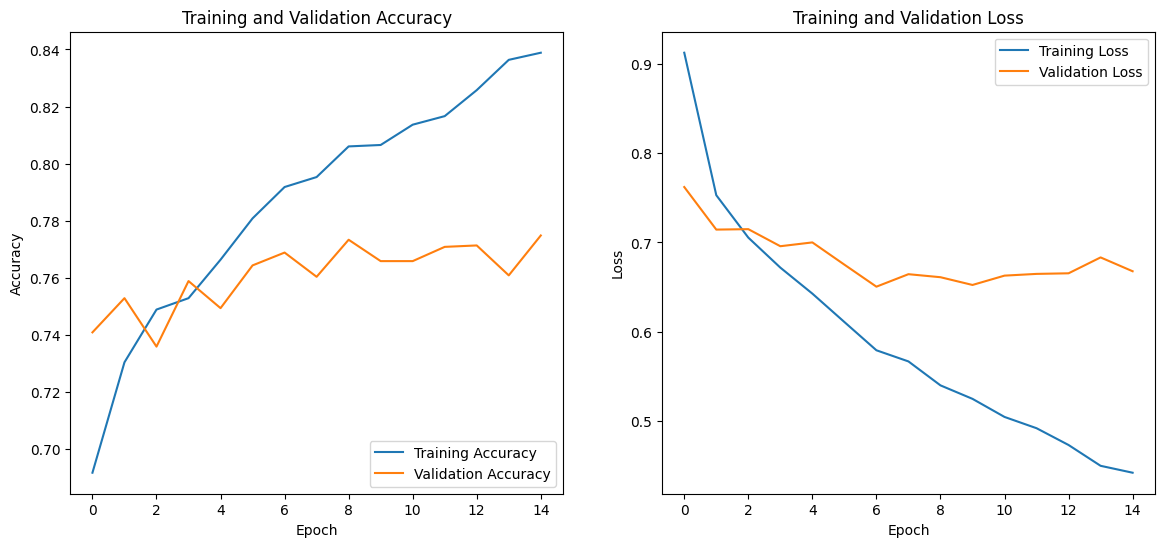

In [ ]:
import matplotlib.pyplot as plt

# --- 1. Get the final validation accuracy and loss ---
final_loss, final_accuracy = model.evaluate(val_dataset)
print(f"\nFinal Validation Loss: {final_loss:.4f}")
print(f"Final Validation Accuracy: {final_accuracy:.4f}")

# --- 2. Plotting the training history ---
print("\n--- Plotting Training History ---")

# Extracting accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Create a figure with two subplots
plt.figure(figsize=(14, 6))

# Subplot 1: Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Subplot 2: Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Show the plots
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# --- 1. Get all the true labels from the validation dataset ---
y_true = []
for images, labels in val_dataset:
    y_true.extend(labels.numpy())

# --- 2. Get the model's predictions for the validation dataset ---
# The model outputs probabilities, so we need the index of the highest probability
y_pred_probs = model.predict(val_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# --- 3. Generate and print the report ---
# We need the actual class names (e.g., 'mel', 'nv') for the report
class_names = encoder.classes_
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names))

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 254ms/step

--- Classification Report ---
              precision    recall  f1-score   support

       akiec       0.46      0.55      0.50        65
         bcc       0.65      0.62      0.63       103
         bkl       0.59      0.39      0.47       220
          df       0.44      0.17      0.25        23
         mel       0.55      0.36      0.43       223
          nv       0.84      0.95      0.89      1341
        vasc       1.00      0.39      0.56        28

    accuracy                           0.77      2003
   macro avg       0.65      0.49      0.53      2003
weighted avg       0.76      0.77      0.76      2003



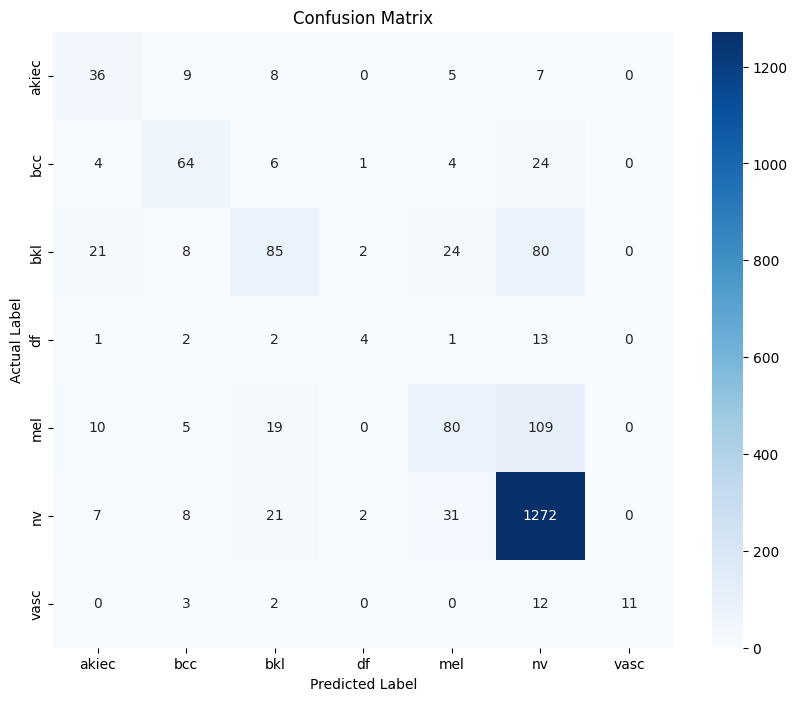

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- 1. Generate the confusion matrix ---
cm = confusion_matrix(y_true, y_pred)

# --- 2. Visualize the confusion matrix with a heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Visualize the Class Distribution ---
plt.figure(figsize=(12, 8))
# Use the 'dx' column for original class codes, and order by count
ax = sns.countplot(x='dx', data=df, order=df['dx'].value_counts().index, palette='viridis')

plt.title('Class Distribution in HAM10000 Dataset')
plt.xlabel('Lesion Type Code')
plt.ylabel('Number of Images')

# Add counts on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

NameError: name 'df' is not defined

<Figure size 1200x800 with 0 Axes>